In [1]:
import IPython

import random
import scipy
import numpy as np # manipulate N-dimensional arrays
import pandas as pd # data frame
import matplotlib.pyplot as plt # data plotting
import seaborn as sns # advanced data plotting
from sklearn import preprocessing # basic ML models
# import scipy # scientific computing library

import tensorflow as tf
import keras
import sklearn as sk

from collections import Counter # Permet de compter le nombre d'éléments qui possèdent chaque label
from keras.utils import to_categorical # One-hot encoding

from keras.models import Model, Sequential
from keras.layers import Input, Dense, BatchNormalization, Dropout, ReLU, Activation, Flatten, Conv2D, MaxPooling2D,LeakyReLU

from keras.backend import clear_session
from keras.optimizers import Adam

from keras.callbacks import EarlyStopping

import os
from keras import backend as K

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from keras.utils import plot_model

from tqdm import tqdm #progress bar


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Préparation des données

In [3]:
data = pd.read_csv("/content/drive/My Drive/stanford-covid-vaccine/data_train.csv")

In [4]:
data.head()

,Unnamed: 0,id,sequence,index_sequence,seq_be,seq_af,structure,struct_be,struct_af,predicted_loop_type,loop_type_be,loop_type_af,bpps_0,bpps_1,bpps_2,bpps_3,bpps_4,bpps_5,bpps_6,bpps_7,bpps_8,bpps_9,bpps_10,bpps_11,bpps_12,bpps_13,bpps_14,bpps_15,bpps_16,bpps_17,bpps_18,bpps_19,bpps_20,bpps_21,bpps_22,bpps_23,bpps_24,bpps_25,bpps_26,bpps_27,...,bpps_74,bpps_75,bpps_76,bpps_77,bpps_78,bpps_79,bpps_80,bpps_81,bpps_82,bpps_83,bpps_84,bpps_85,bpps_86,bpps_87,bpps_88,bpps_89,bpps_90,bpps_91,bpps_92,bpps_93,bpps_94,bpps_95,bpps_96,bpps_97,bpps_98,bpps_99,bpps_100,bpps_101,bpps_102,bpps_103,bpps_104,bpps_105,bpps_106,signal_to_noise,SN_filter,reactivity,deg_Mg_pH10,deg_pH10,deg_Mg_50C,deg_50C
0,0,id_001f94081_0,G,1,O,G,.,O,.,E,O,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006554,0.009221,0.008094,0.021786,0.0,0.0,0.0,0.0,0.0,0.00112,0.0,0.0,0.0,0.0,0.0,0.0,0.004653,0.002415,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.001411,0.0,0.002758,0.005980,0.005979,0.013887,0.0,0.0,0.001528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.009526,0.0,0.0,0.011146,0.0,0.0,0.011636,0.0,0.0,0.010538,0.0,0.0,0.014674,6.894,1,0.3297,0.7556,2.3375,0.3581,0.6382
1,1,id_001f94081_1,G,2,G,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.018205,0.005112,0.038653,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.004323,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.004437,0.0,0.009695,0.003770,0.022915,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005783,0.0,0.0,0.006336,0.0,0.0,0.006032,0.0,0.0,0.005633,0.0,0.0,0.006204,6.894,1,1.5693,2.9830,3.5060,2.9683,3.4773
2,2,id_001f94081_2,A,3,G,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.027590,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.002879,0.000000,0.0,0.000000,0.017502,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,6.894,1,1.1227,0.2526,0.3008,0.2589,0.9988
3,3,id_001f94081_3,A,4,A,A,.,.,.,E,E,E,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001278,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,6.894,1,0.8686,1.3789,1.0108,1.4552,1.3228
4,4,id_001f94081_4,A,5,A,A,.,.,(,E,E,S,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.002843,0.0,0.0,0.0,...,0.0,0.0,0.001408,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,6.894,1,0.7217,0.6376,0.2635,0.7244,0.7877


On ne prend pas les variables suivantes pour deux raisons :

*   Unnamed: 0
*   id
*   index_sequence
*   signal_to_noise	
*   SN_filter	





In [5]:
cols = ['sequence','seq_be','seq_af','structure',	'struct_be',	'struct_af',	'predicted_loop_type',	'loop_type_be',	'loop_type_af']
df=pd.DataFrame()
for name in cols:
  df=pd.concat([df,pd.get_dummies(data[name], prefix=name)],axis=1)
df.head()

,sequence_A,sequence_C,sequence_G,sequence_U,seq_be_A,seq_be_C,seq_be_G,seq_be_O,seq_be_U,seq_af_A,seq_af_C,seq_af_G,seq_af_O,seq_af_U,structure_(,structure_),structure_.,struct_be_(,struct_be_),struct_be_.,struct_be_O,struct_af_(,struct_af_),struct_af_.,struct_af_O,predicted_loop_type_B,predicted_loop_type_E,predicted_loop_type_H,predicted_loop_type_I,predicted_loop_type_M,predicted_loop_type_S,predicted_loop_type_X,loop_type_be_B,loop_type_be_E,loop_type_be_H,loop_type_be_I,loop_type_be_M,loop_type_be_O,loop_type_be_S,loop_type_be_X,loop_type_af_B,loop_type_af_E,loop_type_af_H,loop_type_af_I,loop_type_af_M,loop_type_af_O,loop_type_af_S,loop_type_af_X
0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0
1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
4,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
#data=data[data['SN_filter']==1]

In [9]:
cols=list(df.columns)
for i in range(107):
  cols.append('bpps_'+str(i))
  df['bpps_'+str(i)] = data['bpps_'+str(i)].astype('float32')

In [10]:
X = df[cols]
Y = data[["reactivity",	"deg_Mg_pH10"	,"deg_pH10"	,"deg_Mg_50C",	"deg_50C"]].astype('float32')

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2,stratify=data['index_sequence'])

In [17]:
X_train=np.asarray(X_train)
y_train=np.asarray(y_train)

X_val=np.asarray(X_val)
y_val=np.asarray(y_val)

In [18]:
print(X_train.shape)
dim_x=X_train.shape[1]

(130560, 262)


In [19]:
del data, df, X, Y

# Modèle MLP

In [63]:
clear_session()

In [64]:
def model_MLP():
    model = Sequential()

    model.add(Dense(512, use_bias=True, input_shape=(dim_x,)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(Dropout(0.5))

    model.add(Dense(5,use_bias=True, input_shape=(256,)))
    return model

In [65]:
 def mcrmse(y_true, y_pred):
        cmse = tf.reduce_mean(tf.square(y_true - y_pred), axis=1)
        res = float(tf.reduce_mean(tf.sqrt(cmse)))
        return res

In [66]:
def MLP_loss(y_true,y_pred):
    return mcrmse(y_true, y_pred)

In [67]:
MLP_optimizer = tf.keras.optimizers.Adam(lr=1e-3)

In [58]:
@tf.function
def train_step(x_data,y_data):

    with tf.GradientTape() as MLP_tape:
      y_pred=MLP(x_data,training=True)

      mlp_loss = MLP_loss(y_data,y_pred)

    gradients_of_MLP = MLP_tape.gradient(mlp_loss, MLP.trainable_variables)

    MLP_optimizer.apply_gradients(zip(gradients_of_MLP, MLP.trainable_variables))

In [60]:
EPOCHS = 100
BATCH_SIZE = 256
BUFFER_SIZE = X_train.shape[0]

MLP = model_MLP()
print(MLP.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               134656    
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 512)               0

In [61]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
#idx_history=0
for epoch in tqdm(np.arange(0,EPOCHS)):
  for x_batch,y_batch in train_dataset:
      train_step(x_batch,y_batch)
  y_pred_val=MLP(X_val,training=False)
  print(mcrmse(y_val,y_pred_val))

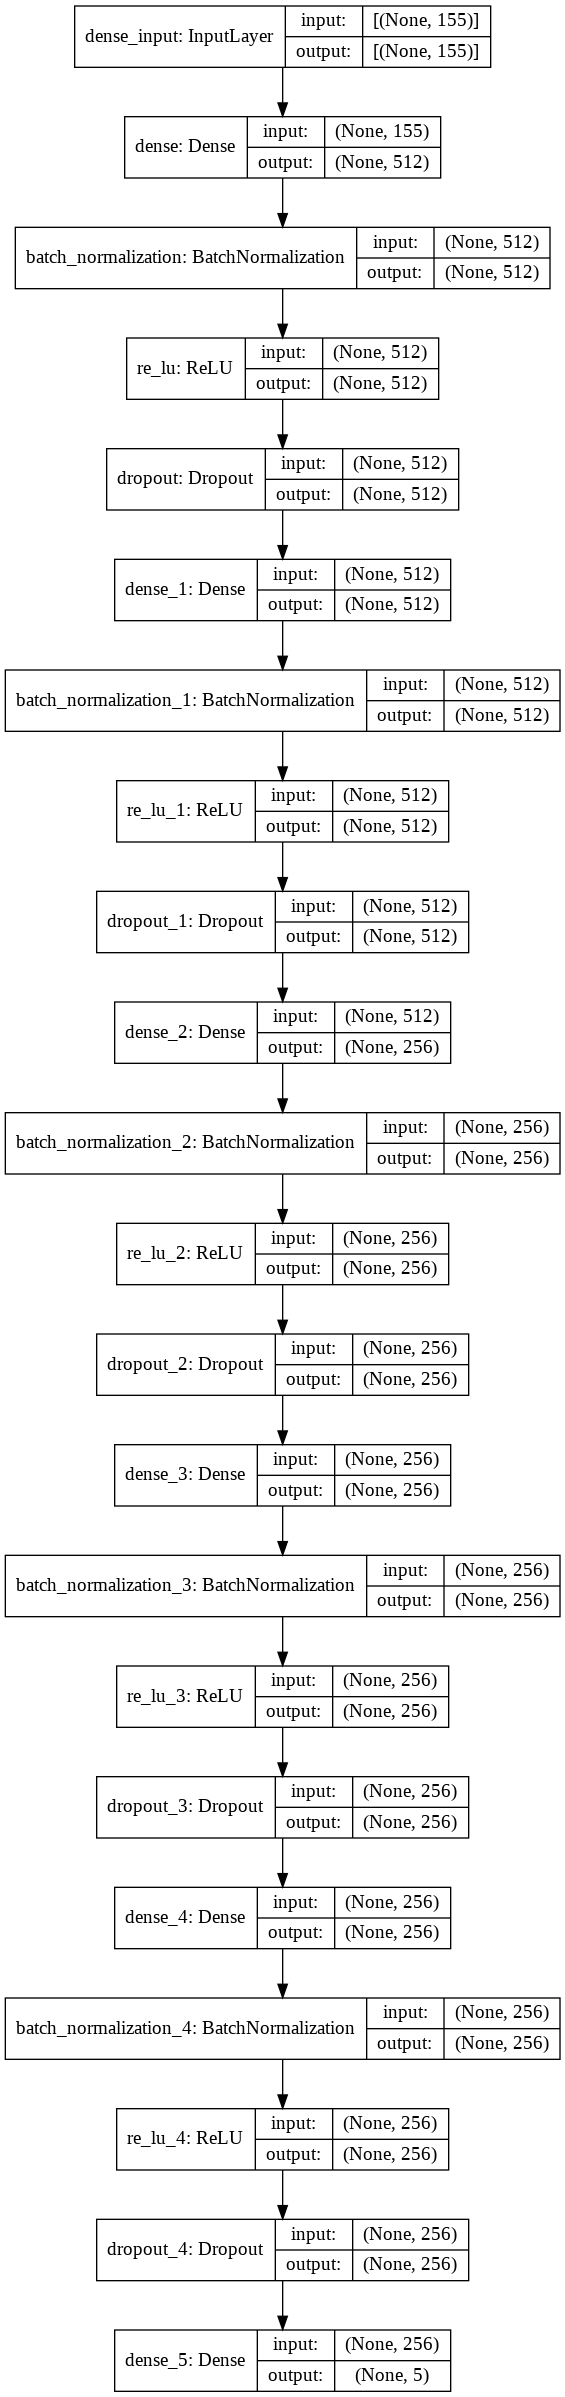

In [80]:
plot_model(MLP,show_shapes=True)